In [23]:
import matplotlib.pyplot as plt
import pandas
import numpy as np
import pycaret.classification as pc
from sklearn import metrics

%matplotlib inline
model_name = 'wine_model'

from pycaret.utils import version
version()

'2.3.6'

# Vinhos


## Leitura da Base 

In [2]:
df_wine = pandas.read_csv('../Data/dataset_vinhos.csv',sep=';')
wine_target_col = 'target'
wine_label_map = df_wine[['target', 'target_label']].drop_duplicates()
print(df_wine.shape)
df_wine.head()

(5320, 14)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,target,target_label,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0,baixa qualidade,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0,baixa qualidade,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0,baixa qualidade,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1,alta qualidade,red
4,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,0,baixa qualidade,red


## Configuração do PyCaret 

In [3]:
# pc.setup?

In [4]:
experiment = pc.setup(session_id=123,
                      data = df_wine, # Configurações de dados
                      train_size=0.6,
                      target = wine_target_col,
                      profile = False, # Analise interativa de variaveis
                      fold_strategy = 'stratifiedkfold', # Validação cruzada
                      fold = 10,
                      normalize = True,  # Normalização, transformação e remoção de variáveis
                      transformation = True, 
                      ignore_low_variance = True,
                      remove_multicollinearity = True,
                      multicollinearity_threshold = 0.95,
                      bin_numeric_features = None, # Binarizacao de variaveis
                      group_features = None, # Grupos de variáveis para combinar na engenharia de variaveis
                      categorical_features = ['type'],
                      ignore_features = ['target_label'],
                      log_experiment = True, # Logging dos experimentos e afins
                      experiment_name = 'wine-model',
                      silent=True)

,Description,Value
0,session_id,123
1,Target,target
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(5320, 14)"
5,Missing Values,False
6,Numeric Features,11
7,Categorical Features,1
8,Ordinal Features,False
9,High Cardinality Features,False


## Seleção de Modelos

In [5]:
# pc.models()
# pc.compare_models?

In [6]:
# pc.models()

In [7]:
# O PyCaret treina os modelos com hiperparametros defaults, sem ajuste fino.
model = pc.compare_models(n_select = 1, sort='Accuracy', include=['lr', 'dt', 'rf'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7628,0.8294,0.8373,0.7993,0.8173,0.4794,0.4818,0.1860
lr,Logistic Regression,0.7409,0.8134,0.8348,0.7745,0.8032,0.4253,0.4286,2.2380
dt,Decision Tree Classifier,0.6726,0.6507,0.7330,0.7461,0.7392,0.2995,0.3000,0.0080


In [8]:
model

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=123, verbose=0,
                       warm_start=False)

## Ajuste de Hiperparâmetros 

In [9]:
# pc.tune_model?

In [10]:
tuned_model = pc.tune_model(model,
                            optimize = 'f1',
                            search_library = 'scikit-learn',
                            search_algorithm = 'random',
                            n_iter = 4)


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7562,0.8186,0.7931,0.8173,0.8050,0.4802,0.4806
1,0.7188,0.7720,0.7291,0.8087,0.7668,0.4149,0.4184
2,0.7461,0.7804,0.8119,0.7923,0.8020,0.4484,0.4487
3,0.6771,0.7437,0.8069,0.7181,0.7599,0.2722,0.2765
4,0.7335,0.7806,0.7772,0.7970,0.7870,0.4315,0.4317
5,0.7398,0.8103,0.7327,0.8362,0.7810,0.4640,0.4701
6,0.7429,0.7850,0.7970,0.7970,0.7970,0.4466,0.4466
7,0.6771,0.7496,0.6980,0.7705,0.7325,0.3278,0.3304
8,0.7492,0.7944,0.8713,0.7652,0.8148,0.4315,0.4403
9,0.7116,0.7623,0.8218,0.7477,0.7830,0.3560,0.3595


## Avaliação do Modelo 

In [11]:
# pc.evaluate_model?
# pc.plot_model?

In [12]:
pc.evaluate_model(tuned_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

## Interpretação dos Resultados 

In [13]:
# pc.interpret_model?

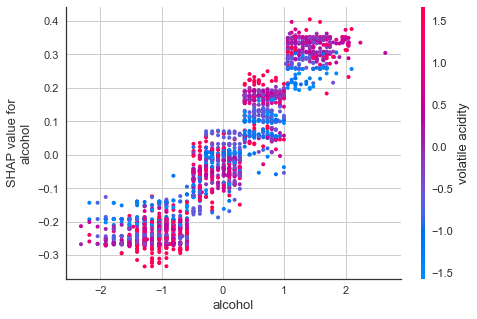

In [15]:
pc.interpret_model(tuned_model, plot='correlation', feature='alcohol')

## Calibração de Modelos 

In [16]:
# pc.calibrate_model?

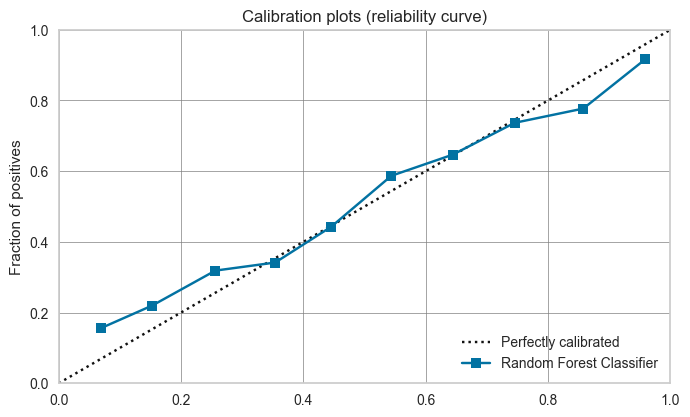

In [17]:
calibrated_model = pc.calibrate_model(tuned_model, method='sigmoid', calibrate_fold=5, fold=5)
pc.plot_model(calibrated_model, plot='calibration')

## Optimização da Operação 

In [18]:
# pc.optimize_threshold(calibrated_model, optimize = 'Precision');

## Avaliação do Teste 

In [19]:
# pc.predict_model?

In [20]:
pred_holdout = pc.predict_model(calibrated_model) # holdout set (test)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.7444,0.7976,0.8641,0.7557,0.8063,0.4355,0.4440


In [21]:
pred_holdout.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type_red,target,Label,Score
0,-0.836000,-0.934320,1.377795,0.806935,-0.078082,0.037492,0.168669,-0.069803,0.016773,-0.153242,-0.478979,0.0,1,1,0.6989
1,0.545191,-0.705740,2.117903,1.527444,-1.121035,1.337881,0.996972,1.137071,-1.518171,0.175725,-1.778469,0.0,0,1,0.5406
2,-0.251246,-0.197295,0.205119,1.163492,-0.017889,0.278647,-0.042539,0.054931,0.202202,0.250689,0.511265,0.0,1,1,0.8117
3,0.748405,-1.177167,0.738319,-0.964131,0.443312,-0.659076,-1.465371,-0.131248,0.439616,1.140042,0.657754,1.0,1,1,0.7882
4,-0.146159,-0.197295,-0.142456,1.452992,0.204725,1.211031,0.626700,0.346471,-1.368544,0.524974,0.014571,0.0,1,1,0.6778


In [27]:
pred_holdout.Score.sum()
# print(metrics.classification_report())

1514.1599999999999

## Finalização do Modelo para Produção

In [28]:
# pc.finalize_model?

In [29]:
final_model = pc.finalize_model(calibrated_model)
pred_final = pc.predict_model(final_model) # holdout set (test)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.7758,0.8383,0.8908,0.7775,0.8303,0.5047,0.5149


## Exportação do Experimento 

In [30]:
# pc.load_config?
# pc.save_config?
# pc.load_model?
# pc.save_model?

In [31]:
pc.save_model(calibrated_model, model_name)

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=['type'],
                                       display_types=False,
                                       features_todrop=['target_label'],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[], target='target',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numeric...
                                                                               class_weight={},
                                                                               criterion='entropy',
                                                                         